In [8]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example data: answers of 6 people to n questions
answers = [
    ["Answer 1 by Person 1", "Answer 2 by Person 1", "Answer 3 by Person 1"],
    ["Answer 1 by Person 2", "Answer 2 by Person 2", "Answer 3 by Person 2"],
    ["Answer 1 by Person 3", "Answer 2 by Person 3", "Answer 3 by Person 3"],
    ["Answer 1 by Person 4", "Answer 2 by Person 4", "Answer 3 by Person 4"],
    ["Answer 1 by Person 5", "Answer 2 by Person 5", "Answer 3 by Person 5"],
    ["Answer 1 by Person 6", "Answer 2 by Person 6", "Answer 3 by Person 6"],
]

# Load the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode answers for each person
embeddings = [model.encode(person_answers) for person_answers in answers]

# Compute pairwise cosine similarity between people
# Flatten embeddings for each person into a single vector (e.g., mean pooling)
flattened_embeddings = [np.mean(person_emb, axis=0) for person_emb in embeddings]

# Calculate cosine similarity
similarity_matrix = cosine_similarity(flattened_embeddings)

# Print the similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)

Cosine Similarity Matrix:
[[1.0000001  0.95898014 0.9408854  0.92412424 0.8999814  0.8735755 ]
 [0.95898014 1.         0.94265205 0.92497253 0.88337606 0.8607444 ]
 [0.9408854  0.94265205 1.0000001  0.92285705 0.8915873  0.87048334]
 [0.92412424 0.92497253 0.92285705 1.0000001  0.8913319  0.8647856 ]
 [0.8999814  0.88337606 0.8915873  0.8913319  1.0000001  0.88523024]
 [0.8735755  0.8607444  0.87048334 0.8647856  0.88523024 1.        ]]


In [9]:
import pandas as pd
# print pandas without truncation
pd.set_option('display.max_columns', None)
annotations = pd.read_csv('Annotations/annotations_6.csv')
print(len(annotations))
# drop rows where not all 6 annotators have annotated
annotations = annotations.groupby('id').filter(lambda x: x['annotator'].nunique() == 6)
print(len(annotations))

# drop rows where "harmful_label" is Flag for Removal
annotations = annotations[annotations['harmful_class'] != 'Flag for Removal']
print(len(annotations))

# for every "intent", remove "the intent is to" from the beginning of the string, regardless of the casing
annotations['intent'] = annotations['intent'].str.replace(r'(?i)^the intent is to', '', regex=True).str.strip()
# for every "intent", remove "to" from the beginning of the string, regardless of the casing
annotations['intent'] = annotations['intent'].str.replace(r'(?i)^to', '', regex=True).str.strip()

annotations = annotations.sort_values(["annotator", "id"])

# group annotations by "annotator"
grouped_annotations = annotations.groupby('annotator')

list_of_intents = []
for annotator, group in grouped_annotations:
    list_of_intents.append(group["intent"].tolist())

print(len(list_of_intents[0]))

answers = list_of_intents
embeddings = [model.encode(person_answers) for person_answers in answers]


250
204
204
34


In [10]:
# Compute Mean Pairwise Cosine Similarity
# Compute overall inter-person agreement
similarities_matrix = np.zeros((len(embeddings), len(embeddings)))
num_questions = len(answers[0])  # Assuming all people answered the same number of questions
print(num_questions)

for q in range(num_questions):
    # Extract embeddings for the current question across all people
    question_embeddings = [embeddings[person][q] for person in range(len(embeddings))]
    similarity_matrix = cosine_similarity(question_embeddings)
    similarities_matrix += similarity_matrix

# Average the similarities over all questions
similarities_matrix /= num_questions

print(similarities_matrix)

# sum = 0
# count = 0
# for i in range(len(embeddings)-1):
#     for j in range(i+1,len(embeddings)):
#         if i != j:
#             print(f"Average similarity between Person {i+1} and Person {j+1}: {similarities_matrix[i][j]}")
#             sum += similarities_matrix[i][j]
#             count += 1
# overall_agreement = sum / count
# print(f"Overall inter-person agreement: {overall_agreement}")

o_a_2 = np.mean([similarities_matrix[i][j] for i in range(len(embeddings)) for j in range(len(embeddings)) if i != j])
print(f"Overall inter-person agreement: {o_a_2}")

34
[[0.99999997 0.65301531 0.59264101 0.47594521 0.61695449 0.58480367]
 [0.65301531 1.00000003 0.66177534 0.55779581 0.65366976 0.62991875]
 [0.59264101 0.66177534 1.00000002 0.57538671 0.65123638 0.65620478]
 [0.47594521 0.55779581 0.57538671 1.00000005 0.56105087 0.5685544 ]
 [0.61695449 0.65366976 0.65123638 0.56105087 1.0000001  0.64420867]
 [0.58480367 0.62991875 0.65620478 0.5685544  0.64420867 1.00000002]]
Overall inter-person agreement: 0.6055440774662239


In [11]:
llm_df = pd.read_csv('Annotations/annotations_with_LLM_responses_Qwen1.5-1.8B-Chat.csv')
#  remove duplicates based on 'id' keeping the first occurrence
llm_df = llm_df.drop_duplicates(subset=['id'], keep='first')

# for every "intent", remove "the intent is to" from the beginning of the string, regardless of the casing
llm_df['LLM_intent'] = llm_df['LLM_intent'].str.replace(r'(?i)^the intent is to', '', regex=True).str.strip()
# for every "intent", remove "to" from the beginning of the string, regardless of the casing
llm_df['LLM_intent'] = llm_df['LLM_intent'].str.replace(r'(?i)^to', '', regex=True).str.strip()
llm_df = llm_df.sort_values("id")
llm_answers = llm_df['LLM_intent'].tolist()

In [12]:
answers_with_llm = answers.copy()
answers_with_llm.append(llm_answers)
embeddings_with_llm = [model.encode(person_answers) for person_answers in answers_with_llm]
similarities_matrix = np.zeros((len(embeddings_with_llm), len(embeddings_with_llm)))
num_questions = len(answers_with_llm[0])  # Assuming all people answered the same number of questions

for q in range(num_questions):
    # Extract embeddings for the current question across all people
    question_embeddings = [embeddings_with_llm[person][q] for person in range(len(embeddings_with_llm))]
    similarity_matrix = cosine_similarity(question_embeddings)
    similarities_matrix += similarity_matrix

# Average the similarities over all questions
similarities_matrix /= num_questions

print(similarities_matrix[:-1,-1])

# get mean similarity between each person and the LLM (last row/column)
mean_similarities = np.mean(similarities_matrix[:-1, -1])
print(f"Mean similarity between each person and the LLM: {mean_similarities}")

[0.30741321 0.35826743 0.32153953 0.31266754 0.33191958 0.3007183 ]
Mean similarity between each person and the LLM: 0.3220875991951199


In [13]:
annotations = pd.read_csv('Annotations/annotations_6.csv')
# drop rows where not all 6 annotators have annotated
annotations = annotations.groupby('id').filter(lambda x: x['annotator'].nunique() == 6)

annotations = annotations.sort_values(["annotator", "id"])

# group annotations by "annotator"
grouped_annotations = annotations.groupby('annotator')

# convert harmful_class labels to numbers
harm_label_mapping = {"Completely Harmful": 3, "Uncertain Harmful": 2, "Uncertain Safe": 1, "Completely Safe": 0}

list_of_harm_label = []
for annotator, group in grouped_annotations:
    list_of_harm_label.append([harm_label_mapping[label] for label in group["harmful_class"].tolist()])


print(len(list_of_harm_label))
print(list_of_harm_label)

6
[[3, 1, 3, 1, 2, 0, 0, 3, 0, 3, 0, 3, 2, 0, 3, 1, 0, 2, 0, 0, 2, 3, 2, 0, 3, 2, 3, 3, 0, 0, 1, 3, 1, 1], [3, 1, 3, 0, 2, 0, 0, 3, 0, 3, 2, 3, 2, 1, 3, 1, 0, 2, 1, 0, 3, 3, 2, 0, 3, 2, 3, 3, 2, 0, 1, 2, 2, 1], [2, 1, 3, 2, 0, 2, 0, 3, 0, 2, 3, 3, 3, 3, 3, 1, 0, 2, 0, 0, 3, 3, 0, 0, 3, 3, 3, 2, 2, 0, 2, 3, 1, 0], [2, 3, 2, 2, 0, 1, 0, 3, 0, 0, 2, 2, 3, 1, 3, 1, 1, 2, 1, 0, 1, 3, 0, 0, 3, 1, 3, 2, 3, 0, 1, 3, 0, 3], [2, 3, 3, 0, 1, 0, 0, 3, 0, 0, 1, 3, 3, 3, 3, 0, 0, 2, 0, 0, 3, 2, 2, 0, 3, 2, 3, 3, 2, 0, 3, 3, 3, 3], [2, 3, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 3, 3, 3, 2, 0, 2, 1, 0, 2, 3, 1, 0, 3, 1, 3, 2, 3, 0, 0, 2, 1, 3]]


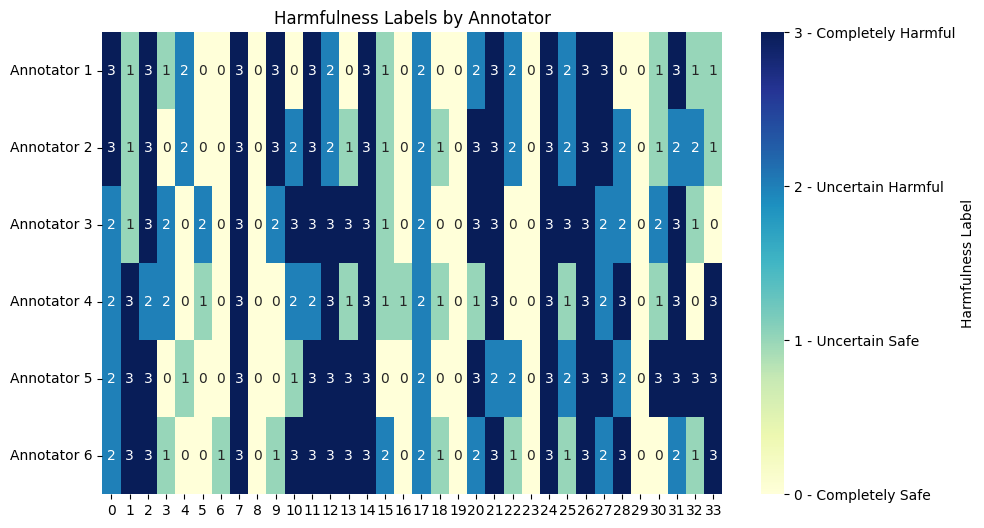

In [14]:
# visualise the harm labels per annotator using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# sns.heatmap(list_of_harm_label, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Harmfulness Level'}, yticklabels=[f'Annotator {i+1}' for i in range(len(list_of_harm_label))])

# ...existing code...
ax = sns.heatmap(
    list_of_harm_label,
    annot=True,
    cmap="YlGnBu",
    cbar_kws={'label': 'Harmfulness Label'},
    yticklabels=[f'Annotator {i+1}' for i in range(len(list_of_harm_label))]
)
# Set colorbar ticks and labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2, 3])
colorbar.set_ticklabels([
    "0 - Completely Safe",
    "1 - Uncertain Safe",
    "2 - Uncertain Harmful",
    "3 - Completely Harmful",
])
plt.title('Harmfulness Labels by Annotator')
plt.show()

In [15]:
import scipy.stats as stats

# Example rankings: Each row represents a statement, and each column represents a person's ranking
# rankings = np.array([
#     [5, 5, 5, 5, 5, 5],  # Rankings of statement 1
#     [1, 1, 5, 1, 5, 2],  # Rankings of statement 2
#     [1, 1, 5, 2, 3, 1],  # Rankings of statement 3
#     [2, 2, 5, 4, 1, 3],  # Rankings of statement 4
#     [1, 1, 1, 4, 1, 3],  # Rankings of statement 5
# ])

rankings = np.array(list_of_harm_label)
# transpose rankings to have statements as rows and annotators as columns
rankings = rankings.T

# Function to calculate pairwise Kendall's tau and Spearman correlation
def calculate_pairwise_agreement(rankings):
    num_annotators = rankings.shape[1]
    kendall_tau_values = []
    spearman_values = []
    kendall_tau_matrix = np.zeros((num_annotators, num_annotators))
    spearman_matrix = np.zeros((num_annotators, num_annotators))

    # Iterate over all pairs of annotators
    for i in range(num_annotators):
        for j in range(i + 1, num_annotators):
            tau, _ = stats.kendalltau(rankings[:, i], rankings[:, j])
            rho, _ = stats.spearmanr(rankings[:, i], rankings[:, j])

            # Handle cases where tau or rho is NaN
            tau = tau if not np.isnan(tau) else 0
            rho = rho if not np.isnan(rho) else 0

            kendall_tau_values.append(tau)
            spearman_values.append(rho)
            kendall_tau_matrix[i, j] = tau
            kendall_tau_matrix[j, i] = tau
            spearman_matrix[i, j] = rho
            spearman_matrix[j, i] = rho

    # Calculate average Kendall's tau and Spearman correlation
    avg_kendall_tau = np.mean(kendall_tau_values)
    avg_spearman = np.mean(spearman_values)

    return avg_kendall_tau, avg_spearman, kendall_tau_matrix, spearman_matrix

# Calculate pairwise agreement
avg_kendall_tau, avg_spearman, kendall_tau_matrix, spearman_matrix = calculate_pairwise_agreement(rankings)

# Calculate overall annotator agreement as the average of Kendall's tau and Spearman correlation
overall_agreement = (avg_kendall_tau + avg_spearman) / 2

# Function to print the bottom half of a matrix
def print_bottom_half(matrix):
    for i in range(matrix.shape[0]):
        for j in range(i + 1):
            print(f"{matrix[i, j]:.2f}", end="\t")
        print()

print(f"Average Kendall's Tau: {avg_kendall_tau}")
print(f"Average Spearman Correlation: {avg_spearman}")
print(f"Overall Annotator Agreement: {overall_agreement}")
print("Bottom Half of Pairwise Kendall's Tau Matrix:")
print_bottom_half(kendall_tau_matrix)
print("Bottom Half of Pairwise Spearman Correlation Matrix:")
print_bottom_half(spearman_matrix)

Average Kendall's Tau: 0.5561796184994441
Average Spearman Correlation: 0.63396315531039
Overall Annotator Agreement: 0.5950713869049171
Bottom Half of Pairwise Kendall's Tau Matrix:
0.00	
0.81	0.00	
0.53	0.59	0.00	
0.42	0.41	0.55	0.00	
0.51	0.55	0.54	0.53	0.00	
0.43	0.54	0.61	0.72	0.60	0.00	
Bottom Half of Pairwise Spearman Correlation Matrix:
0.00	
0.88	0.00	
0.60	0.69	0.00	
0.49	0.49	0.63	0.00	
0.59	0.63	0.62	0.61	0.00	
0.48	0.63	0.68	0.82	0.68	0.00	
